<a href="https://colab.research.google.com/github/zain711/dcipher/blob/main/IndianNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]
!pip install bert-extractive-summarizer
!pip install plotly
!pip install torch
!pip install tensorflow
!pip install flair

In [2]:
!pip install 'umap-learn==0.5.0'

     |████████████████████████████████| 81kB 3.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.0-cp37-none-any.whl size=76337 sha256=cd58458b34b24e4791bd05bc08c4d312e67230d60bd9d0db7381a412a186ef5c
  Stored in directory: /root/.cache/pip/wheels/c6/64/c4/6ff874f1bfedf37c36d1799b6f3da78c5bbcde007fbda096aa
Successfully built umap-learn
  Found existing installation: umap-learn 0.5.1
    Uninstalling umap-learn-0.5.1:
      Successfully uninstalled umap-learn-0.5.1


In [3]:
import json
import pandas as pd
import torch
from bertopic import BERTopic
import os
import nltk 
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer , WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip list -v | grep bertopic

bertopic                      0.6.0          /usr/local/lib/python3.7/dist-packages pip      


## **Preprocessing Text**

In [5]:
#previous vaccine forums
data = pd.read_json('/content/drive/MyDrive/IndianNews-minified.json')
docs = list(data.loc[:, "text"].values)
times = list(data.loc[:, "date"].values)

In [6]:
data.head(5)

,date,text
0,2021-03-30 18:28:49+00:00,The Haryana born athlete says she took solace ...
1,2021-03-30 18:26:51+00:00,and anxiety . Here is a list of food items t...
2,2021-03-30 18:24:17+00:00,"” According to Architectural Record, numerou..."
3,2021-03-30 18:08:48+00:00,Count on this simple breathing exercise to rel...
4,2021-03-30 18:02:23+00:00,It's become a place where I find most of my ne...


In [7]:
import re
wnl = WordNetLemmatizer()
ps = PorterStemmer()

#tokens = list(data.loc[:, "tokens"].values)
new_tokens = []
for_embed = []
rem_num = []
my_tokens = []

docs_lower = [k.lower() for k in docs]
#remove numbers and symbols from token list and lemmatize
for b in docs_lower:
  rem_num.append(re.sub('[0-9]+', '', b)) #remove numerical tokens

for a in rem_num:
  new_tokens.append(re.sub(r'[^\w]', ' ', a))

for c in new_tokens:
  my_tokens.append(" ".join([wnl.lemmatize(a) for a in c.split()]))

#split tokens for word embeddings
for c in new_tokens:
  for_embed.append(c.split())

In [8]:
#clean times for topic evolution visualization
clean_times = []
for a in times:
  ts = pd.to_datetime(str(a)) 
  d = ts.strftime('%Y.%m.%d')
  clean_times.append(d)

In [11]:
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt 

#calculate and graph loss of embeddings
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.epochs = []
        self.losses = []

    def on_epoch_end(self, modeling):
        plt.axis([0, 100, 0, 3000000])
        loss = modeling.running_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        epochs = self.epoch
        losses = loss_now
        plt.plot(self.epoch, loss_now, '.r-')
        self.epoch += 1
        if (self.epoch == 100):
           plt.show()

# **TRAINING W2V AND FT MODELS**

Loss after epoch 0: 4525649.5
Loss after epoch 1: 3430574.5
Loss after epoch 2: 3001672.0
Loss after epoch 3: 2852769.0
Loss after epoch 4: 2864706.0
Loss after epoch 5: 2493349.0
Loss after epoch 6: 2402002.0
Loss after epoch 7: 2457836.0
Loss after epoch 8: 2401782.0
Loss after epoch 9: 2438248.0
Loss after epoch 10: 2440576.0
Loss after epoch 11: 2347484.0
Loss after epoch 12: 1550228.0
Loss after epoch 13: 1610844.0
Loss after epoch 14: 1607412.0
Loss after epoch 15: 1585752.0
Loss after epoch 16: 1596256.0
Loss after epoch 17: 1555612.0
Loss after epoch 18: 1602172.0
Loss after epoch 19: 1573992.0
Loss after epoch 20: 1597016.0
Loss after epoch 21: 1618408.0
Loss after epoch 22: 1575648.0
Loss after epoch 23: 1583132.0
Loss after epoch 24: 1576980.0
Loss after epoch 25: 1582132.0
Loss after epoch 26: 1621072.0
Loss after epoch 27: 1612820.0
Loss after epoch 28: 1575340.0
Loss after epoch 29: 1612036.0
Loss after epoch 30: 1574592.0
Loss after epoch 31: 1639188.0
Loss after epoch 3

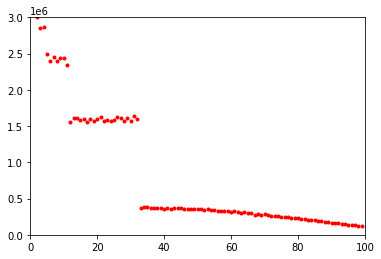

(638423966, 831529000)

In [43]:
model = Word2Vec(window = 5, min_count = 10) #increase min_count
model.build_vocab(for_embed)  # prepare the model vocabulary
model.train(for_embed, total_examples=model.corpus_count, epochs=100, compute_loss = True, callbacks=[callback()])

In [44]:
#save word2vec embeddings for model training
word_vectors = model.wv
word_vectors.save("/content/drive/My Drive/word2vec_indian")

In [36]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/word2vec_indian")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [ ]:
from gensim.models import FastText 

modeling = FastText(size=100, window=5, min_count=10) 
modeling.build_vocab(sentences=for_embed)
modeling.train(for_embed, total_examples=len(for_embed), epochs=100, sg = 1, compute_loss=True)  # set sg = 1

In [49]:
word_vectorss = modeling.wv
word_vectorss.save("/content/drive/My Drive/fasttext_indian2")

In [ ]:
len(my_tokens)

100228

In [21]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

glove_embedding = WordEmbeddings("/content/drive/My Drive/fasttext_indian2")
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [39]:
#this model recommends training with 50 topics or above
topic_model = BERTopic(nr_topics = 5, embedding_model = document_glove_embeddings)

In [42]:
topics, prob = topic_model.fit_transform(new_tokens)

In [43]:
#remove stop words and change n-gram range
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

stop_word =['don', 'doesn', 'didn', 'isn', 'aren', 'https', 'won', 'haven']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word)
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
topic_model.update_topics(new_tokens, topics, vectorizer_model=cv)
# 5 - 0.6189575597782422, 0.6412429685319271
# 10 - 0.6222194350640053, ft2 0.6786574184468597

In [44]:
cm = CoherenceModel(topics=get_topic_list(topic_model), texts = for_embed, dictionary = dictionary, coherence='c_v')
coherence = cm.get_coherence()
coherence

0.5544627155531007

In [27]:
def get_topic_list(topic_model):
  dictionary = list(topic_model.get_topics().values())
  diction = dictionary[1:] #remove outlier topic
  p = 0
  final_t = []
  for i in range(len(diction)):
    final_t.append([])

  for key in diction:
     for i in key:
          final_t[p].append(i[0])
     p+=1
  return final_t

In [26]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
dictionary = corpora.Dictionary(for_embed)
corpus = [dictionary.doc2bow(text) for text in for_embed]

In [45]:
all_coherences = [0.618957559778242, 0.6222194350640053, 0.5740515670804616, 0.5605505700836383, 0.5544627155531007]

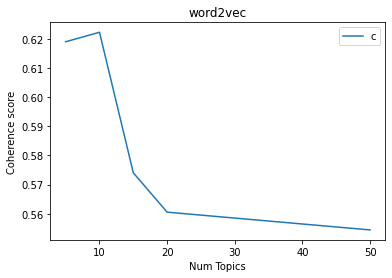

In [46]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = [5,10,15,20,50]
plt.plot(x, all_coherences)
plt.title("word2vec")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
topic_model.save('/content/drive/My Drive/indian_ft5')

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [34]:
np.save('/content/drive/My Drive/topic_india10ft5', topics)
#np.save('/content/drive/My Drive/prob_india', prob)

In [47]:
fasttext = BERTopic.load('/content/drive/My Drive/indian_ft102')
ftop = np.load('/content/drive/My Drive/topic_india10ft2.npy')

In [48]:
fasttext.visualize_topics()

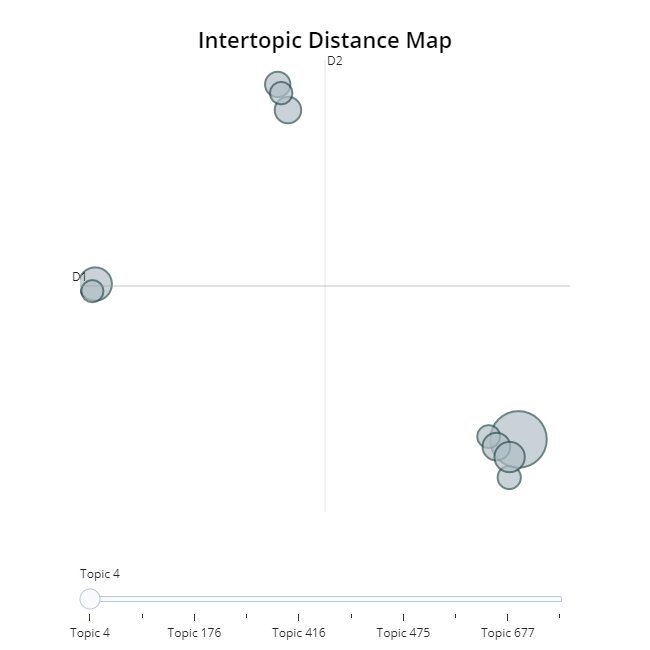

In [137]:
topics_over_time = fasttext.topics_over_time(new_tokens, ftop, clean_times, nr_bins=20, global_tuning=False)

In [138]:
fasttext.visualize_topics_over_time(topics_over_time, top_n=10)

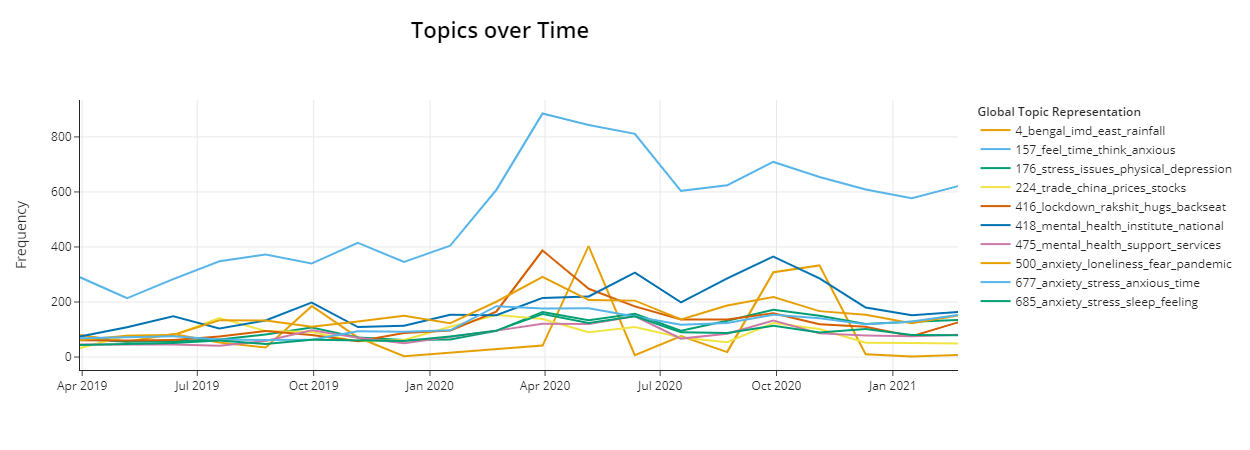

In [49]:
w2v = BERTopic.load('/content/drive/My Drive/indian_w2v10')
topw2v = np.load('/content/drive/My Drive/topic_india10.npy')

In [50]:
w2v.visualize_topics()

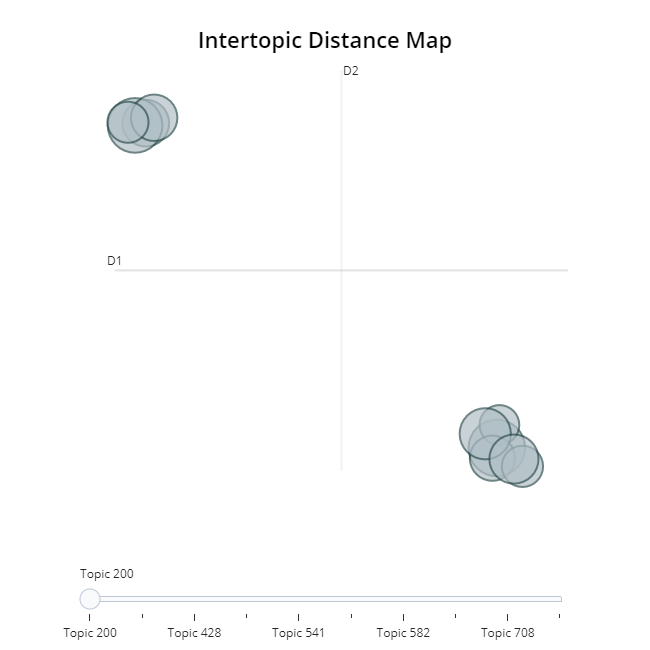

In [141]:
topics_over_time = w2v.topics_over_time(new_tokens, topw2v, clean_times, nr_bins=20, global_tuning=False)

In [142]:
w2v.visualize_topics_over_time(topics_over_time, top_n=10)

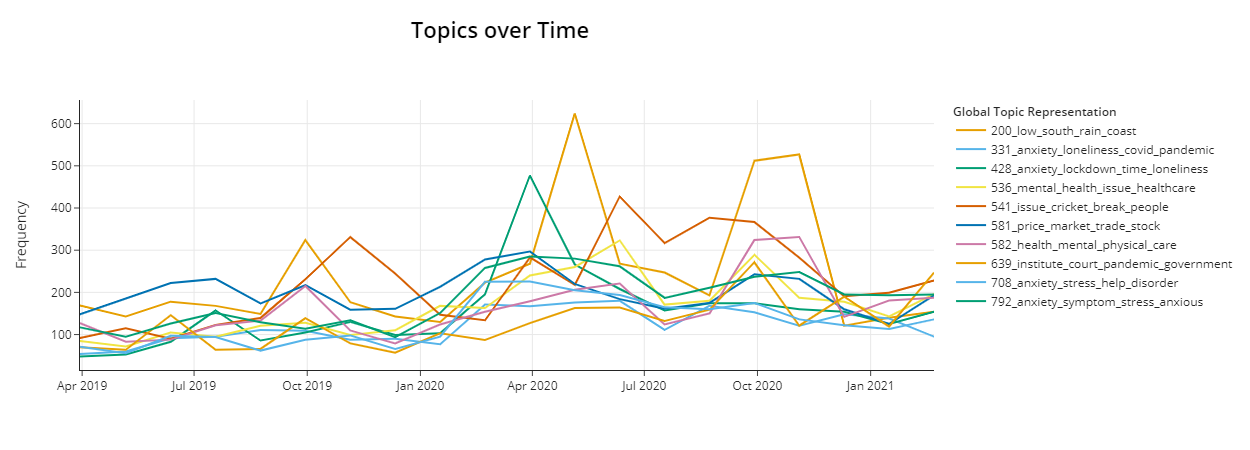

# **EXTRA**

In [50]:
# Get the clusterer model, the clusters' tree and the clusters (topics ids)
clusterer = topic_model.hdbscan_model
tree = clusterer.condensed_tree_
clusters = tree._select_clusters()

# Get the ids of the most relevant documents (exemplars) associated with the topic at index idx
c_exemplars = topic_model.get_most_relevant_documents(clusters[325], tree)

In [ ]:
c_exemplars

In [ ]:
for i in c_exemplars:   
    print(f"Document: {docs[i]}")
    print("-----------")
   # print(new_tokens[found_docs[i]]) 
    print("-----------")
    print()


In [9]:
import umap.umap_ as umap
import hdbscan
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)

# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10,
                                min_samples=1,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)